query utilizada: 
```
--select count(*) from 
select c.empresa as idUnidade,
c.pessoa as idPessoa,
e.nome as nomeUnidade, 
c.situacao as situacaoMatricula, 
c.plano as idPlano, 
p.descricao as tipoPlano, 
p2.nome as nomePessoa, 
('2022-05-31' - p2.datanasc::date)/365 as idadePessoa,
p2.sexo as sexoPessoa, 
endereco.endereco as Rua,
endereco.bairro as Bairro,
cidade.nome as Cidade,
estado.descricao as Estado,
endereco.cep as CEP
 --, p2.estadocivil, p2.profissao, p2.estadocivil 
from contrato c
left join empresa e on c.empresa = e.codigo 
left join plano p on c.plano = p.codigo
left join pessoa p2 on c.pessoa = p2.codigo
left join estado on p2.estado = estado.codigo 
left join cidade on p2.cidade = cidade.codigo
left join endereco on p2.codigo = endereco.pessoa 
where e.nome = 'GOLDEN SHOPPING' 
and c.vigenciade::date >= '2019-01-01'
-- and c.situacao = = 'AT'
-- where c.situacao = 'AT' and e.nome = 'GOLDEN SHOPPING'```

Importando bibliotecas

In [38]:
import requests
import json
import pandas as pd
import urllib.request
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
import matplotlib.pyplot as plt

In [66]:
sns.set_palette("Set1")

Lendo o CSV gerado pela query:

In [39]:
df = pd.read_csv('Golden.csv', sep = ',', on_bad_lines= 'skip')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18892 entries, 0 to 18891
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idunidade          18892 non-null  int64  
 1   idpessoa           18892 non-null  int64  
 2   nomeunidade        18892 non-null  object 
 3   situacaomatricula  18892 non-null  object 
 4   idplano            18892 non-null  int64  
 5   tipoplano          18892 non-null  object 
 6   nomepessoa         18892 non-null  object 
 7   idadepessoa        18865 non-null  float64
 8   sexopessoa         18866 non-null  object 
 9   rua                18548 non-null  object 
 10  bairro             18548 non-null  object 
 11  cidade             18032 non-null  object 
 12  estado             18482 non-null  object 
 13  cep                18547 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 2.0+ MB


In [41]:
df.head()

,idunidade,idpessoa,nomeunidade,situacaomatricula,idplano,tipoplano,nomepessoa,idadepessoa,sexopessoa,rua,bairro,cidade,estado,cep
0,133,1322136,GOLDEN SHOPPING,AT,4,PLANO SELF LIGHT MENSAL,RENATA CRISTINA DE OLIVEIRA LIMA MOURA,29.0,F,AVENIDA ALFA,PARQUE ATHENAS,SÃO LUÍS,MARANHÃO,65.072-110
1,133,1472636,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,YAN LUCAS MONTEIRO COSTA,20.0,M,RUA OITO,VINHAIS,SÃO LUÍS,MARANHÃO,65.071-100
2,133,1474381,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,RAQUEL RODRIGUES NEIVA,49.0,f,NaN,NaN,NaN,NaN,NaN
3,133,1361820,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,MARIA PAULA SILVA E SILVA,27.0,f,Travessa da Paz,Angelim,SÃO LUÍS,MARANHÃO,65063510
4,133,1361820,GOLDEN SHOPPING,CA,3,PLANO SELF LIGHT,MARIA PAULA SILVA E SILVA,27.0,f,Travessa da Paz,Angelim,SÃO LUÍS,MARANHÃO,65063510


<b><h3> Limpeza e Formatação do Dataset</h3></b>

verificando campos nulos:

In [42]:
df.isnull().sum()

idunidade              0
idpessoa               0
nomeunidade            0
situacaomatricula      0
idplano                0
tipoplano              0
nomepessoa             0
idadepessoa           27
sexopessoa            26
rua                  344
bairro               344
cidade               860
estado               410
cep                  345
dtype: int64

convertendo idade para inteiro.

In [43]:
df.idadepessoa.describe()

count    18865.000000
mean        35.873946
std         23.525842
min         10.000000
25%         28.000000
50%         34.000000
75%         41.000000
max       1822.000000
Name: idadepessoa, dtype: float64

In [44]:
df['idadepessoa'] = df['idadepessoa'].fillna(0.0).astype(int)

Ajustando a idade dos clientes.

In [45]:
df = df.loc[(df.idadepessoa > 10 ) & (df.idadepessoa < 70)]

dropando linhas que tem conteúdo importante como nulo, ex: sexo e idade

In [46]:
df = df[df.sexopessoa.notnull()]
df = df[df.idadepessoa.notnull()]

drop na coluna nome, pois é irrelevante estatisticamente

In [47]:
df.drop(['nomepessoa'], axis = 1, inplace = True)

In [48]:
df.head()

,idunidade,idpessoa,nomeunidade,situacaomatricula,idplano,tipoplano,idadepessoa,sexopessoa,rua,bairro,cidade,estado,cep
0,133,1322136,GOLDEN SHOPPING,AT,4,PLANO SELF LIGHT MENSAL,29,F,AVENIDA ALFA,PARQUE ATHENAS,SÃO LUÍS,MARANHÃO,65.072-110
1,133,1472636,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,20,M,RUA OITO,VINHAIS,SÃO LUÍS,MARANHÃO,65.071-100
2,133,1474381,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,49,f,NaN,NaN,NaN,NaN,NaN
3,133,1361820,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,27,f,Travessa da Paz,Angelim,SÃO LUÍS,MARANHÃO,65063510
4,133,1361820,GOLDEN SHOPPING,CA,3,PLANO SELF LIGHT,27,f,Travessa da Paz,Angelim,SÃO LUÍS,MARANHÃO,65063510


Padronizando variavel de Sexo - convertendo p/ maiúsculo

In [49]:
df['sexopessoa'] = df['sexopessoa'].str.upper()

covnvertendo caracteres de sexo para maíusculo

In [50]:
df.head()

,idunidade,idpessoa,nomeunidade,situacaomatricula,idplano,tipoplano,idadepessoa,sexopessoa,rua,bairro,cidade,estado,cep
0,133,1322136,GOLDEN SHOPPING,AT,4,PLANO SELF LIGHT MENSAL,29,F,AVENIDA ALFA,PARQUE ATHENAS,SÃO LUÍS,MARANHÃO,65.072-110
1,133,1472636,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,20,M,RUA OITO,VINHAIS,SÃO LUÍS,MARANHÃO,65.071-100
2,133,1474381,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,49,F,NaN,NaN,NaN,NaN,NaN
3,133,1361820,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,27,F,Travessa da Paz,Angelim,SÃO LUÍS,MARANHÃO,65063510
4,133,1361820,GOLDEN SHOPPING,CA,3,PLANO SELF LIGHT,27,F,Travessa da Paz,Angelim,SÃO LUÍS,MARANHÃO,65063510


Limpando lixos de preenchimento do "CEP"

In [51]:
#exlcluindo valores nulos
df = df[df.cep.notnull()]

In [52]:
df['cep'] = df['cep'].fillna(0) #preenche vazios com zero
df['cep'] = df['cep'].replace('\.', '', regex = True,)
df['cep'] = df['cep'].replace('-', '', regex = True,)
df['cep'] = df['cep'].replace(' ', '' ,regex=True)
df = df[df['cep'] != '0']
df = df[df['cep'] != 0]

verificando a quantidade diferente de planos que estão na Golden Shopping

In [53]:
df['tipoplano'].value_counts()

PLANO SELF PLUS SITE             5583
PLANO SELF PLUS                  4689
PLANO SELF LIGHT                 2752
PLANO SELF LIGHT SITE            1966
DAY USE                          1702
PLANO SELF LIGHT MENSAL           975
PLANO PLUS CORP                   326
PLANO SELF PLUS MENSAL            303
PLANO SELF PLUS TOTAL              16
PLANO ACOLHEDOR PLUS               16
PLANO EMBAIXADOR PLUS              12
PLANO SELF LIGHT TOTAL             11
CORTESIA MENSAL PLUS COVID19        6
PLANO CORTESIA PLUS                 1
CORTESIA MENSAL LIGHT COVID19       1
Name: tipoplano, dtype: int64

filtrando apenas os planos mais relevantes, temos:

In [54]:
df = df.loc[(df.tipoplano != 'PLANO SELF LIGHT TESTE-SITE') & 
                  (df.tipoplano != 'CORTESIA MENSAL PLUS COVID19') &
                  (df.tipoplano != 'CORTESIA MENSAL LIGHT COVID19') &
                  (df.tipoplano != 'PLANO EMBAIXADOR PLUS') &
                  (df.tipoplano != 'PLANO CORTESIA PLUS') &
                  (df.tipoplano != 'PLANO SELF PLUS MENSAL') &
                  (df.tipoplano != 'PLANO ACOLHEDOR PLUS') &
                  (df.tipoplano != 'PLANO SELF LIGHT MENSAL') &
                  (df.tipoplano != 'PLANO SELF LIGHT TOTAL') &
                  (df.tipoplano != 'PLANO SELF PLUS TOTAL') &
                  (df.tipoplano != 'PLANO PLUS CORP') 
                # &(df.tipoplano != 'DAY USE') 
                  ]

In [55]:
df.tipoplano.value_counts()

PLANO SELF PLUS SITE     5583
PLANO SELF PLUS          4689
PLANO SELF LIGHT         2752
PLANO SELF LIGHT SITE    1966
DAY USE                  1702
Name: tipoplano, dtype: int64

cep não pode ser numero inteiro, pois se tiver um cep do tipo '09' será convertido em '9' e não será possivel buscar na API

In [22]:
df.head()

,idunidade,idpessoa,nomeunidade,situacaomatricula,idplano,tipoplano,idadepessoa,sexopessoa,rua,bairro,cidade,estado,cep
0,133,1322136,GOLDEN SHOPPING,AT,4,PLANO SELF LIGHT MENSAL,29,F,AVENIDA ALFA,PARQUE ATHENAS,SÃO LUÍS,MARANHÃO,65072110
1,133,1472636,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,20,M,RUA OITO,VINHAIS,SÃO LUÍS,MARANHÃO,65071100
3,133,1361820,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,27,F,Travessa da Paz,Angelim,SÃO LUÍS,MARANHÃO,65063510
4,133,1361820,GOLDEN SHOPPING,CA,3,PLANO SELF LIGHT,27,F,Travessa da Paz,Angelim,SÃO LUÍS,MARANHÃO,65063510
5,133,1310827,GOLDEN SHOPPING,AT,9,PLANO SELF PLUS SITE,33,F,RUA CORONEL PAIVA,TURU,SÃO LUÍS,MARANHÃO,65066290


In [23]:
pd.crosstab([df.estado ,df.cidade, df.nomeunidade],
            [ df.situacaomatricula],
            margins = False).style.background_gradient(cmap = 'RdYlGn')

fica evidente que os dados mais relevantes são da cidade de São Luis, mas pq tem gente de outros estados e cidades com situações de matricula nessa unidade? Esses dados são relevantes? 

Vamos filtrar somente o estado do Maranhão pra verificar.

In [24]:
pd.crosstab([df.estado[df.estado == 'MARANHÃO'] ,df.cidade, df.nomeunidade],
            [ df.situacaomatricula],
            margins = False).style.background_gradient(cmap = 'RdYlGn')

Ainda assim, a capital é a cidade mais importante e fica evidente que a unidade fica inserida na capital. Será que houve desatualização de cadastros de endereço das pessoas nas matrículas?

Após filtrar o estado do Maranhão na análise, vamos verificar a situação da matricula.

In [59]:
df.situacaomatricula.value_counts()

CA    7631
IN    6472
AT    2585
TR       4
Name: situacaomatricula, dtype: int64

Existem apenas 4 trancados da unidade Golden em todo o estado do Maranhão, portanto, vamos descartá-los

In [60]:
df = df.loc[(df.situacaomatricula != 'TR')]

In [62]:
df.situacaomatricula.value_counts()

CA    7631
IN    6472
AT    2585
Name: situacaomatricula, dtype: int64

DESCARTADOS.

<h1><b> EDA </h1></b>

<b><h3> Sexo -> Variavel Categorica <h3/></b>

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18359 entries, 0 to 18891
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   idunidade          18359 non-null  int64 
 1   idpessoa           18359 non-null  int64 
 2   nomeunidade        18359 non-null  object
 3   situacaomatricula  18359 non-null  object
 4   idplano            18359 non-null  int64 
 5   tipoplano          18359 non-null  object
 6   idadepessoa        18359 non-null  int64 
 7   sexopessoa         18359 non-null  object
 8   rua                18359 non-null  object
 9   bairro             18359 non-null  object
 10  cidade             17822 non-null  object
 11  estado             18264 non-null  object
 12  cep                18359 non-null  object
dtypes: int64(4), object(9)
memory usage: 2.5+ MB


/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


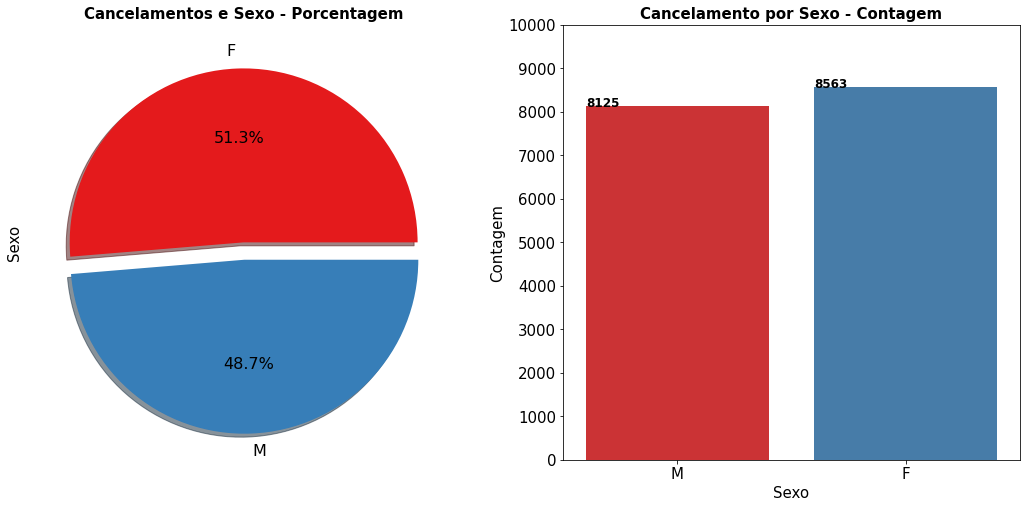

In [67]:
f, ax = plt.subplots(1,2, figsize = (18,8))
#Grafico 1
df['sexopessoa'].value_counts().plot.pie(
    explode = [0,0.1], # tamanho do da lacuna entre os valores do gráfico de torta
                                        autopct ='%1.1f%%' , # 
                                        ax = ax[0], #indica onde será plotado a figura, na coluna 1.
                                        shadow = True,
                                        fontsize = 16                         
)
ax[0].set_title("Cancelamentos e Sexo - Porcentagem", fontsize = 15, fontweight = 'bold')
ax[0].set_ylabel("Sexo", fontsize =15)

#Grafico 2
b = sns.countplot('sexopessoa',
              data = df,
              ax = ax[1],
              )
b.tick_params(labelsize= 15)
b.set_yticks(range(0,11000, 1000))
ax[1].set_title("Cancelamento por Sexo - Contagem", fontsize = 15, fontweight = 'bold')
ax[1].set_ylabel("Contagem", fontsize = 15)
ax[1].set_xlabel("Sexo", fontsize = 15)
for i in ax[1].patches:
    # get_width pulls left or right; get_y pushes up or down
    ax[1].text(i.get_x(), i.get_height(), \
            str(round((i.get_height()), 1)),
            fontsize=12,
            color='black',
           weight = 'bold')

mulheres são maioria, apenas 400 a mais.

/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


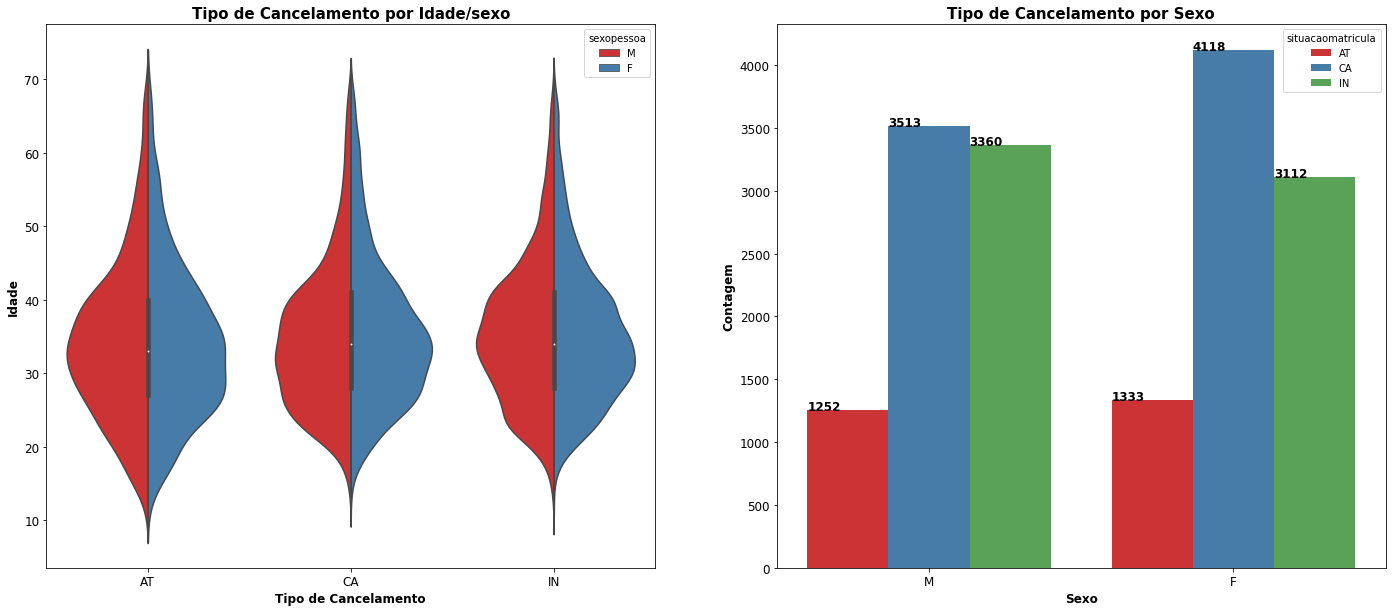

In [77]:
f, ax = plt.subplots(1, 2, figsize = (24,10))

sns.violinplot('situacaomatricula',
               'idadepessoa',
               hue = 'sexopessoa',
               split = True,
               data = df,
               ax = ax[0])

ax[0].set_title("Tipo de Cancelamento por Idade/sexo", fontsize = 15, fontweight = 'bold')
ax[0].set_xlabel("Tipo de Cancelamento", fontsize = 12, fontweight = 'bold')
ax[0].set_ylabel("Idade", fontsize = 12, fontweight = 'bold')
ax[0].tick_params(labelsize =12)


sns.countplot('sexopessoa',
              hue = 'situacaomatricula',
              data = df,
              ax = ax[1])

ax[1].set_title("Tipo de Cancelamento por Sexo", fontsize = 15, fontweight = 'bold')
ax[1].set_ylabel("Contagem", fontsize = 12, fontweight = 'bold')
ax[1].set_xlabel("Sexo", fontsize = 12, fontweight = 'bold')
ax[1].tick_params(labelsize =12)
for i in ax[1].patches:
    # get_width pulls left or right; get_y pushes up or down
    ax[1].text(i.get_x(), i.get_height(), \
            str(round((i.get_height()), 1)),
            fontsize=12,
            color='black',
           weight = 'bold')

Existem 500 mulheres a mais na situação cancelada do que homens. 
No entanto, existem apenas 400 mulheres a mais do que homens em toda academia.. Seria uma tendencia do sexo feminino cancelar mais do que o sexo masculino? homens realmente tendem a não cancelar seus planos? 

Existem apenas (1333 - 1252) 81 mulheres a mais na academia com situação de ativo. O sexo está bem "empatado" neste quesito.

/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


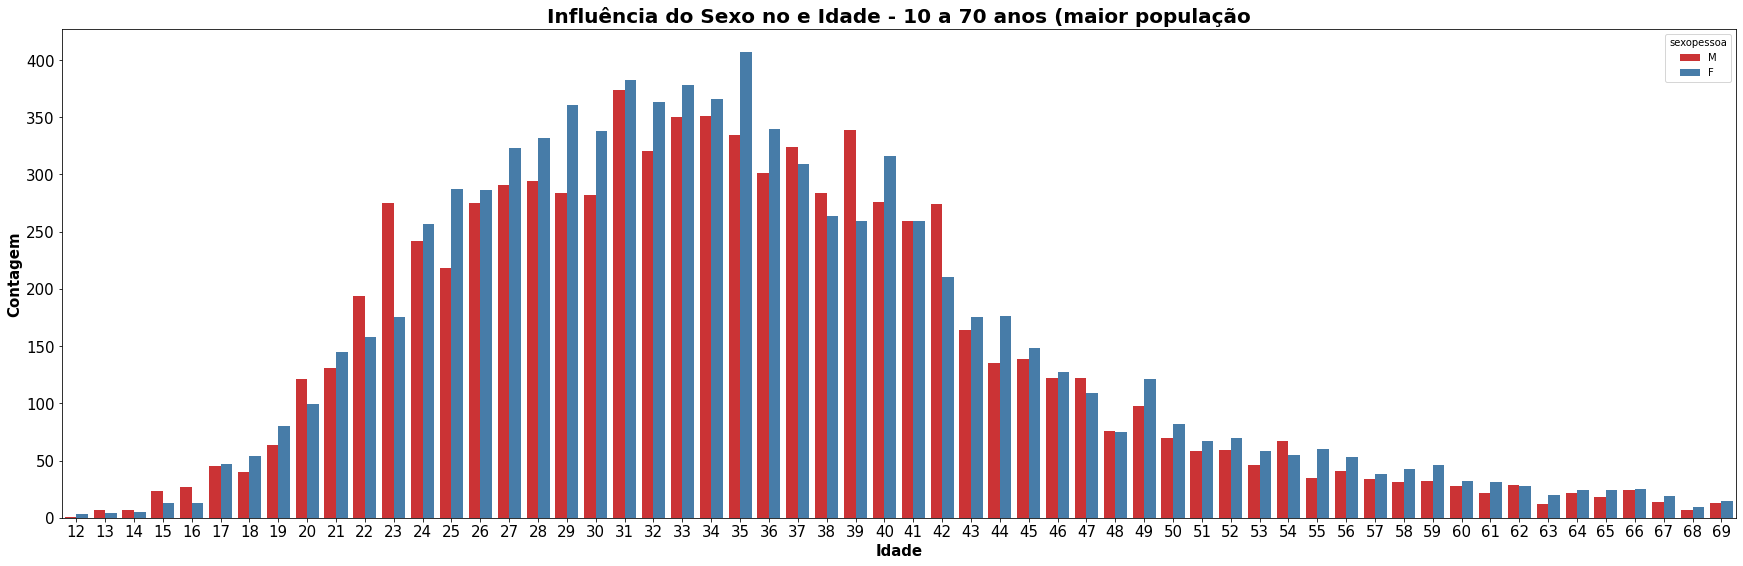

In [68]:
fig = sns.countplot('idadepessoa',
              hue = 'sexopessoa',
              data = df)
fig.set_title("Influência do Sexo no e Idade - 10 a 70 anos (maior população", fontsize = 20, fontweight ='bold')
fig.set_xlabel("Idade", fontsize = 15, fontweight ='bold')
fig.set_ylabel("Contagem", fontsize = 15, fontweight ='bold')
fig.tick_params(labelsize =15)
    
plt.gcf().set_size_inches(30,9)

In [78]:
df_idade_20_30 = df.loc[(df.idadepessoa >= 20) & (df.idadepessoa <= 30)]
df_idade_30_40 = df.loc[(df.idadepessoa > 30) & (df.idadepessoa <= 40)]
df_idade_40_60 = df.loc[(df.idadepessoa > 40) & (df.idadepessoa <= 60)]

/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


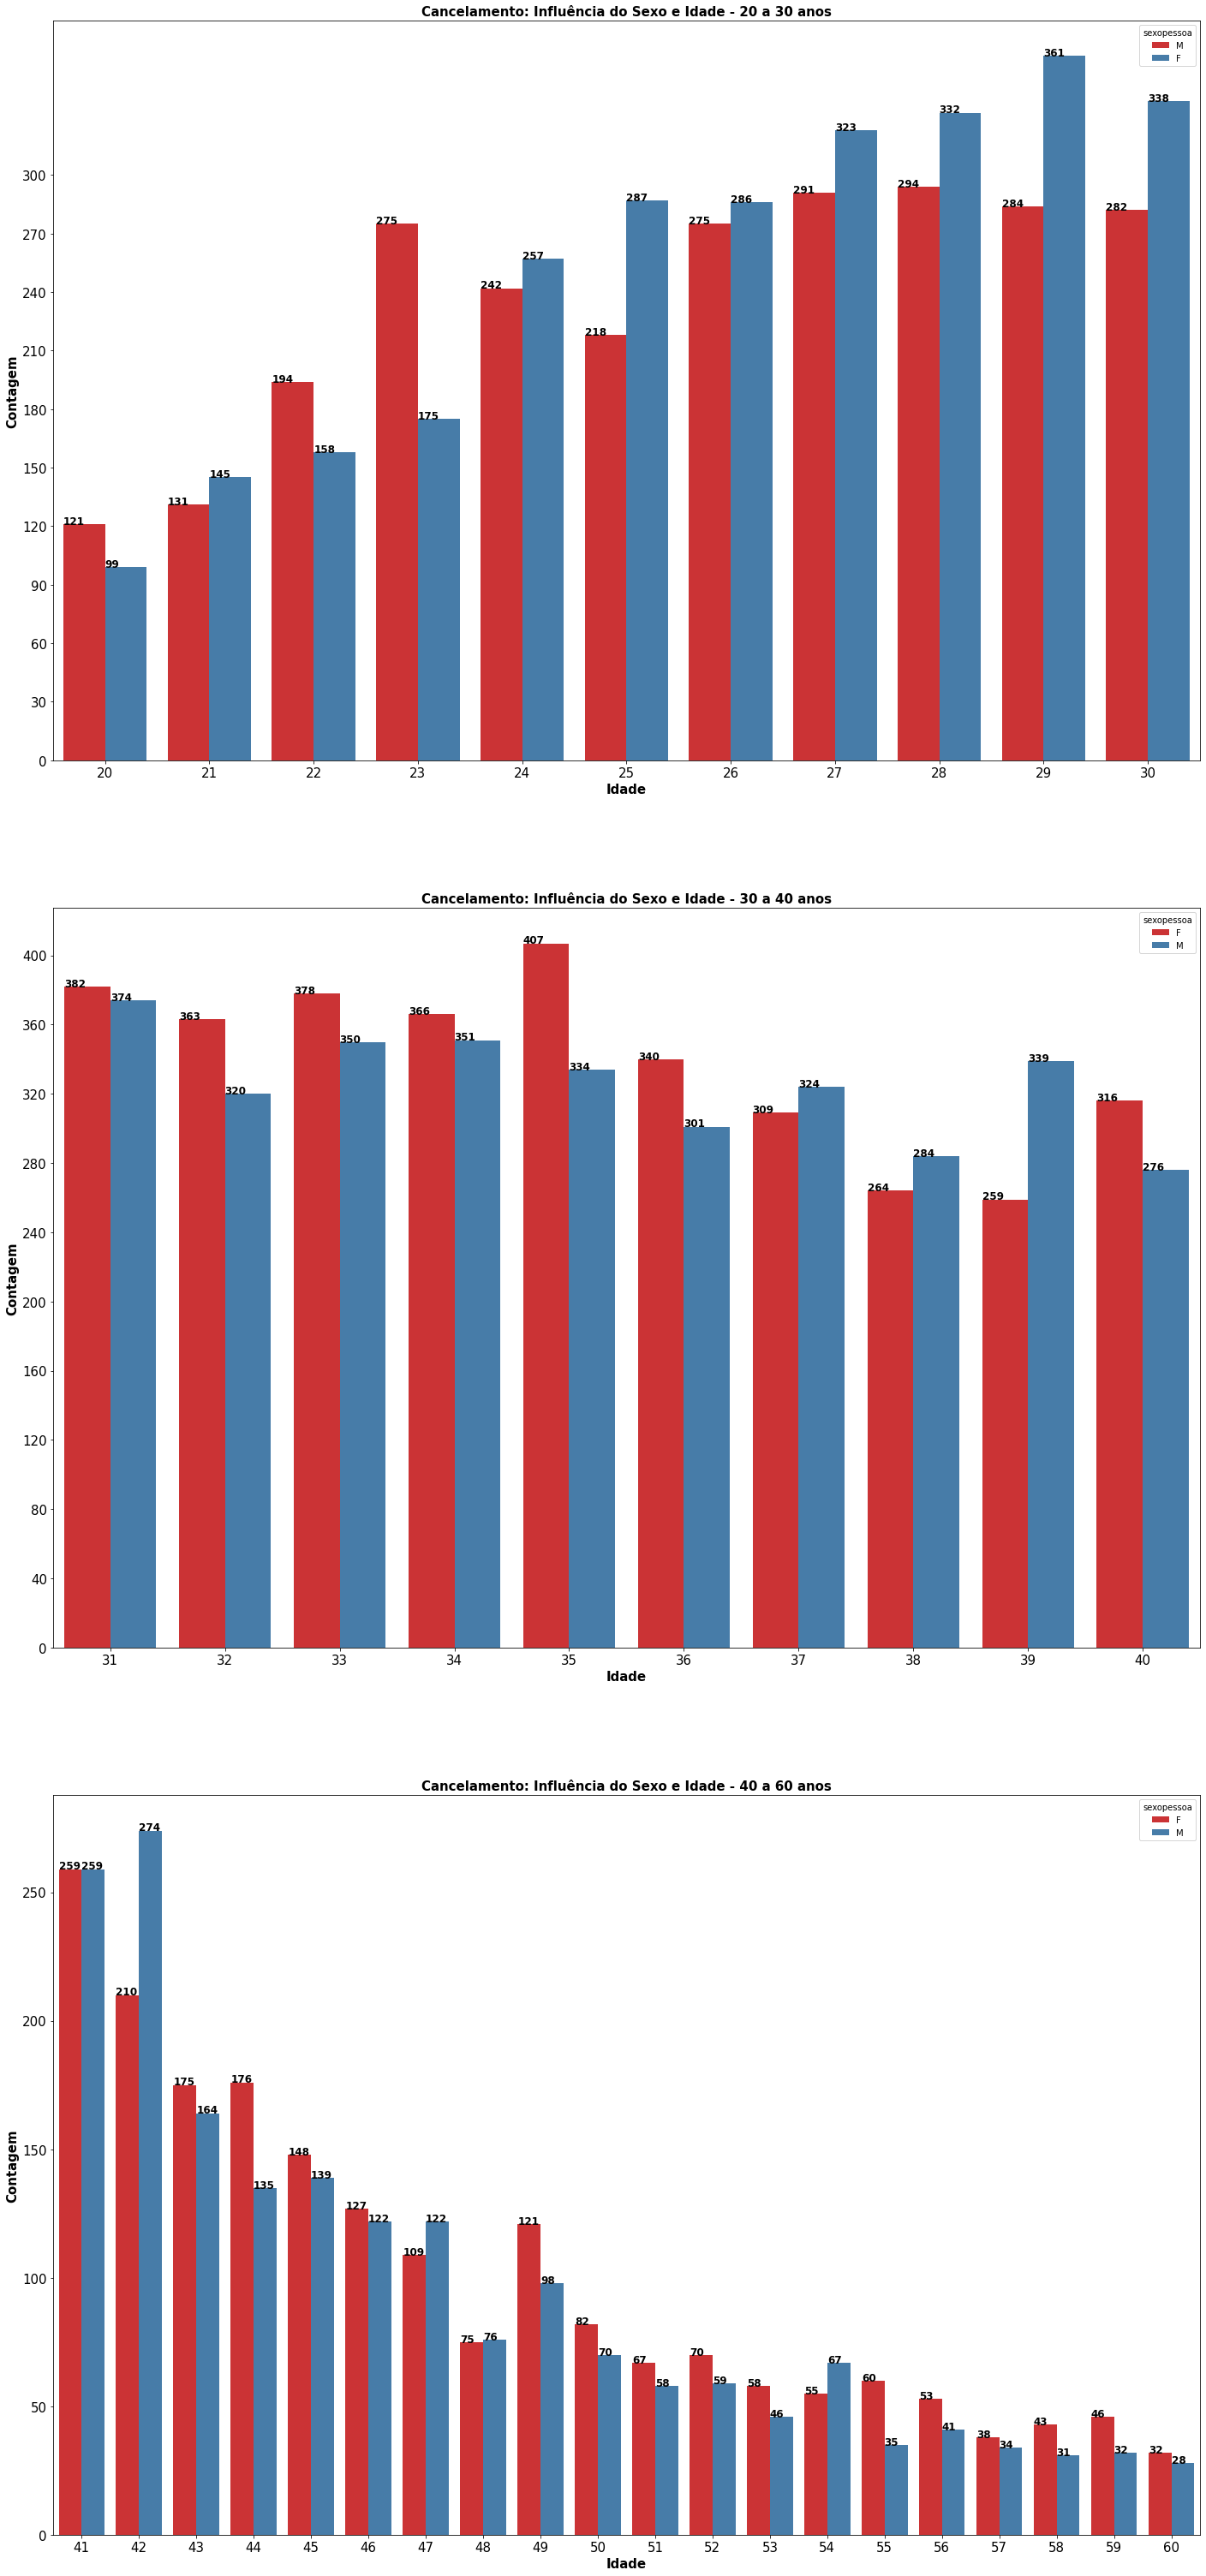

In [83]:
f, ax = plt.subplots(3,1, figsize = (24,54))
#figura 1
sns.countplot('idadepessoa',
              hue = 'sexopessoa',
              data = df_idade_20_30,
              ax = ax[0])
ax[0].set_yticks(range(0,330, 30))
for i in ax[0].patches:
    ax[0].text(i.get_x(), i.get_height(), str(i.get_height()),fontsize=12,color='black',weight = 'bold')
    
ax[0].set_title("Cancelamento: Influência do Sexo e Idade - 20 a 30 anos", fontsize = 15, fontweight = 'bold')
ax[0].set_xlabel("Idade", fontsize = 15, fontweight ='bold')
ax[0].set_ylabel("Contagem", fontsize = 15, fontweight ='bold')
ax[0].tick_params(labelsize =15)

#figura 2
sns.countplot('idadepessoa',
              hue = 'sexopessoa',
              data = df_idade_30_40,
              ax = ax[1])

ax[1].set_yticks(range(0,440, 40))
for i in ax[1].patches:
    ax[1].text(i.get_x(), i.get_height(), str(i.get_height()),fontsize=12,color='black',weight = 'bold')

ax[1].set_title("Cancelamento: Influência do Sexo e Idade - 30 a 40 anos", fontsize = 15, fontweight = 'bold')
ax[1].set_xlabel("Idade", fontsize = 15, fontweight ='bold')
ax[1].set_ylabel("Contagem", fontsize = 15, fontweight ='bold')
ax[1].tick_params(labelsize =15)
#figura 3
sns.countplot('idadepessoa',
            hue = 'sexopessoa',
            data = df_idade_40_60,
            ax = ax[2])

for i in ax[2].patches:
    ax[2].text(i.get_x(), i.get_height(), str(i.get_height()),fontsize=12,color='black',weight = 'bold')
    
ax[2].set_title("Cancelamento: Influência do Sexo e Idade - 40 a 60 anos", fontsize = 15, fontweight = 'bold')
ax[2].set_xlabel("Idade", fontsize = 15, fontweight ='bold')
ax[2].set_ylabel("Contagem", fontsize = 15, fontweight ='bold')
ax[2].tick_params(labelsize =15)


plt.show()

/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


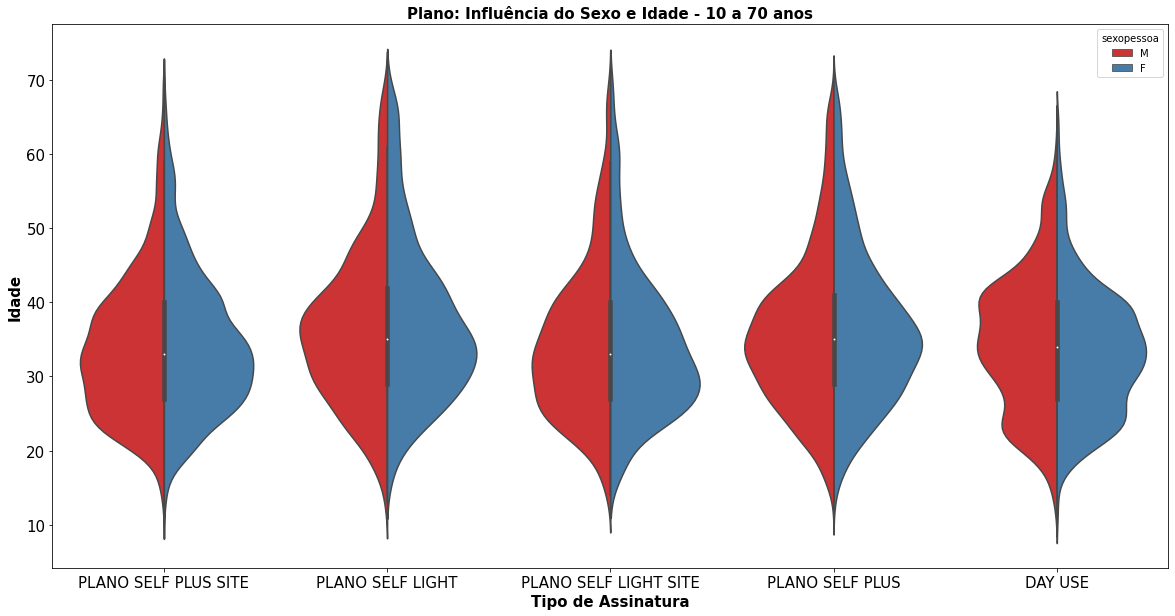

In [84]:
fig = sns.violinplot('tipoplano',
               'idadepessoa',
               hue = 'sexopessoa',
               split = True,
               data = df)

fig.set_title("Plano: Influência do Sexo e Idade - 10 a 70 anos", fontsize = 15, fontweight = 'bold')
fig.set_xlabel("Tipo de Assinatura", fontsize = 15, fontweight ='bold')
fig.set_ylabel("Idade", fontsize = 15, fontweight ='bold')
fig.tick_params(labelsize =15)

fig = plt.gcf()

fig.set_size_inches(20,10)

grafico do day use é o único com "shape" diferente dos demais, sendo bem ondulado. Maioria das pessoas que "experimentam" a academia como day use são mulheres.

Seria interessante criar uma campanha de retenção de usuários mulheres para a academia?

filtrando a idade das mulheres

In [88]:
df.idadepessoa[(df['tipoplano'] == 'DAY USE') & (df['sexopessoa'] == 'F')].describe()

count    767.000000
mean      33.195567
std        8.473324
min       12.000000
25%       27.000000
50%       33.000000
75%       39.000000
max       64.000000
Name: idadepessoa, dtype: float64

vemos que a idade média do tipo Day use é de 33 anos.  os quartis ainda mostram que um grande volume de mulheres tem idade entre 27 e 39 anos..

Ajustar!!!

/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


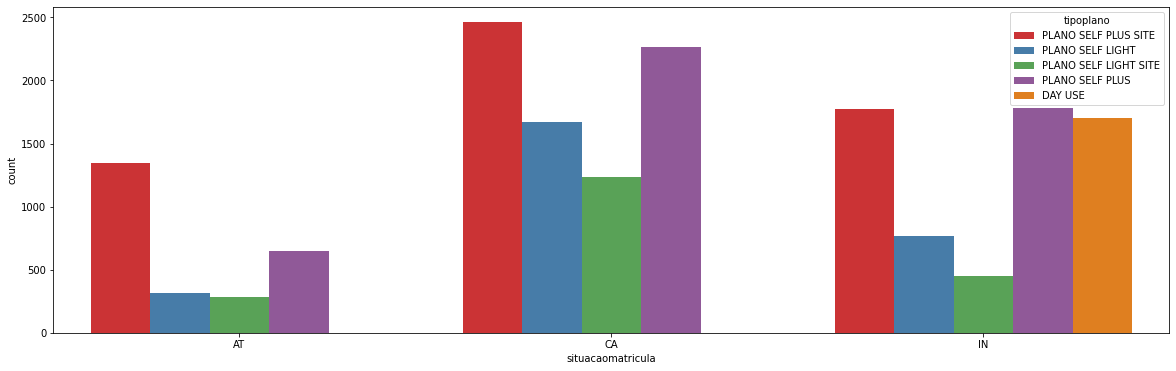

In [69]:
sns.countplot("situacaomatricula",
              hue = "tipoplano",
              data = df)

fig = plt.gcf()

fig.set_size_inches(20,6)

Parece que só existe plano day use na situação INATIVO, verificando:

In [72]:
df.situacaomatricula.loc[df['tipoplano'] == 'DAY USE'].value_counts()

IN    1702
Name: situacaomatricula, dtype: int64

de fato, so existe Day Use para IN ( inativos )

In [76]:
df.to_csv('teste.csv', sep = ';', encoding='UTF-8')

In [49]:
'''
conteudo = ''
    for i in df['cep'].iloc[1:]:
    url = "https://viacep.com.br/ws/{}/json/".format(i)
    headers = {'User-Agent': 'Autociencia/1.0'}
    requisicao = urllib.request.Request(url, headers=headers, method='GET')
    cliente = urllib.request.urlopen(requisicao)
    conteudo += str(cliente.read().decode('utf-8'))
    #print(conteudo)
    cliente.close()
    
    '''

'\n\n    for i in df[\'cep\'].iloc[1:]:\n    url = "https://viacep.com.br/ws/{}/json/".format(i)\n    headers = {\'User-Agent\': \'Autociencia/1.0\'}\n    requisicao = urllib.request.Request(url, headers=headers, method=\'GET\')\n    cliente = urllib.request.urlopen(requisicao)\n    conteudo += str(cliente.read().decode(\'utf-8\'))\n    #print(conteudo)\n    cliente.close()\n    \n    '